In [1]:
from dictionary_learning.trainers.top_k import AutoEncoderTopK
from musicsae.nnsight_model import MusicGenLanguageModel, AutoProcessor
import torch
from utils import MODELS_DIR, OUTPUT_DATA_DIR, INPUT_DATA_DIR, DATA_DIR
import torchaudio
import nnsight

device = "cuda:1"
model_name = "facebook/musicgen-medium"
max_tokens = 200
base_dir = INPUT_DATA_DIR / "music-bench" / "datashare-instruments"
model_sr = 32000

In [2]:
nn_model = MusicGenLanguageModel(model_name, device_map=device)

Config of the text_encoder: <class 'transformers.models.t5.modeling_t5.T5EncoderModel'> is overwritten by shared text_encoder config: T5Config {
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "classifier_dropout": 0.0,
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
      "num_beams": 4,
      "prefix": "summ

In [3]:
processor = AutoProcessor.from_pretrained(model_name)

In [4]:
ae = AutoEncoderTopK.from_pretrained(
    MODELS_DIR / "medium-sae-trivial-medium-sae-ee3b" / "16" / "trainer_0" / "checkpoints" / "ae_71100.pt"
).to(device)

/home/pgryz/wimu/music-sae/.venv/lib/python3.10/site-packages/dictionary_learning/trainers/top_k.py:129: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = t.load(pa

In [5]:
layer = nn_model.decoder.model.decoder.layers[16]

In [6]:
prompt = "Prominent use of string instruments like violins, guitars, and other stringed instruments, often with melodic roles."
# prompt = "Lively Scottish bagpipe tune in G mixolydian mode, featuring a continuous drone, traditional grace notes, and a strong, march-like rhythm"
prompt = "This is an alternative rock song with slow tempo and guitar and drums"

tokens = 255
n = 1
# set_seed(42)

zs = []

with nn_model.generate([prompt] * n, max_new_tokens=tokens):
    outputs = nnsight.list().save()
    act = nnsight.list().save()

    for i in range(tokens):
        if i % 5 != 0:
            continue

        z = ae.encode(layer.output[0][:], use_threshold=True)
        zs.append(z.save())

        # layer.output[0][:] = ae.decode(z)

        outputs.append(nn_model.generator.output)
        nn_model.next()

for i in range(n):
    torchaudio.save(
        OUTPUT_DATA_DIR / "musicgen-sae" / f"out_{i}.wav",
        src=outputs[0][i].detach().cpu(),
        sample_rate=nn_model.config.sampling_rate,
        channels_first=True,
    )

Config of the text_encoder: <class 'transformers.models.t5.modeling_t5.T5EncoderModel'> is overwritten by shared text_encoder config: T5Config {
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "classifier_dropout": 0.0,
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
      "num_beams": 4,
      "prefix": "summ

In [7]:
from src.heatmap import create_heatmap, plot_heatmap, filter_heatmap_top_k_features, filter_heatmap_min_duration

zs = [zi[0][0] for zi in zs]
heatmap = create_heatmap(zs)

In [8]:
HeatMap = dict

1114


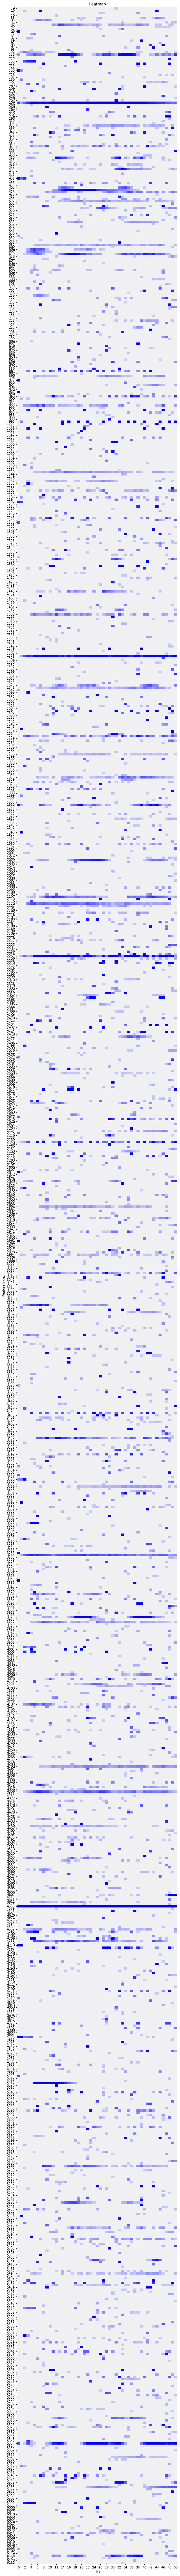

In [9]:
a = plot_heatmap(heatmap)
print(len(heatmap.keys()))
a.savefig("heatmap_a.png", dpi=300)

In [10]:
def filter_heatmap(heatmap: HeatMap, min_active_duration: int = 2) -> HeatMap:
    result = dict()

    for key, value in heatmap.items():
        if len(value) - value.count(0) >= min_active_duration:
            result[key] = value

    return result

53


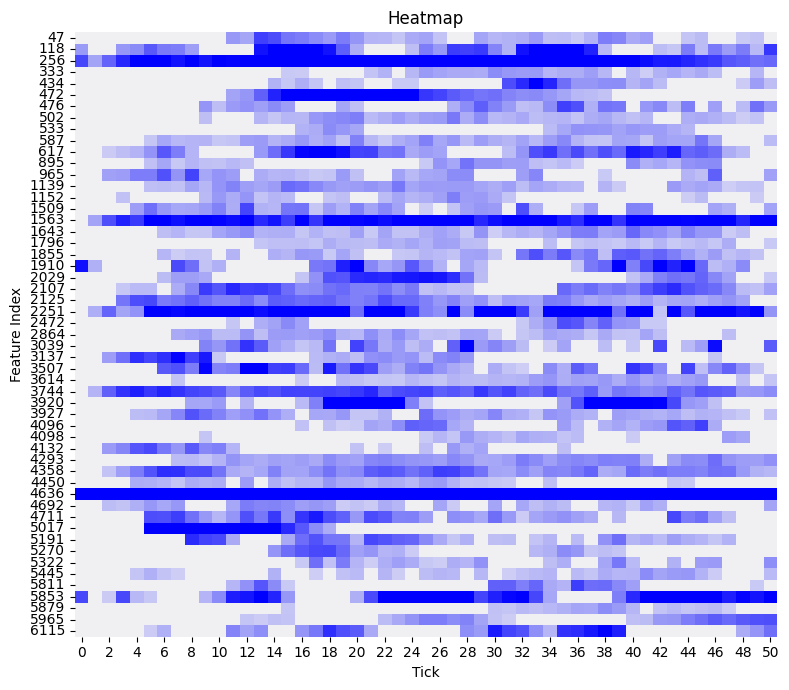

In [11]:
heatmap_b = filter_heatmap_min_duration(heatmap, 10)
print(len(heatmap_b.keys()))
b = plot_heatmap(heatmap_b)
b.savefig("heatmap_b.png", dpi=300)

100


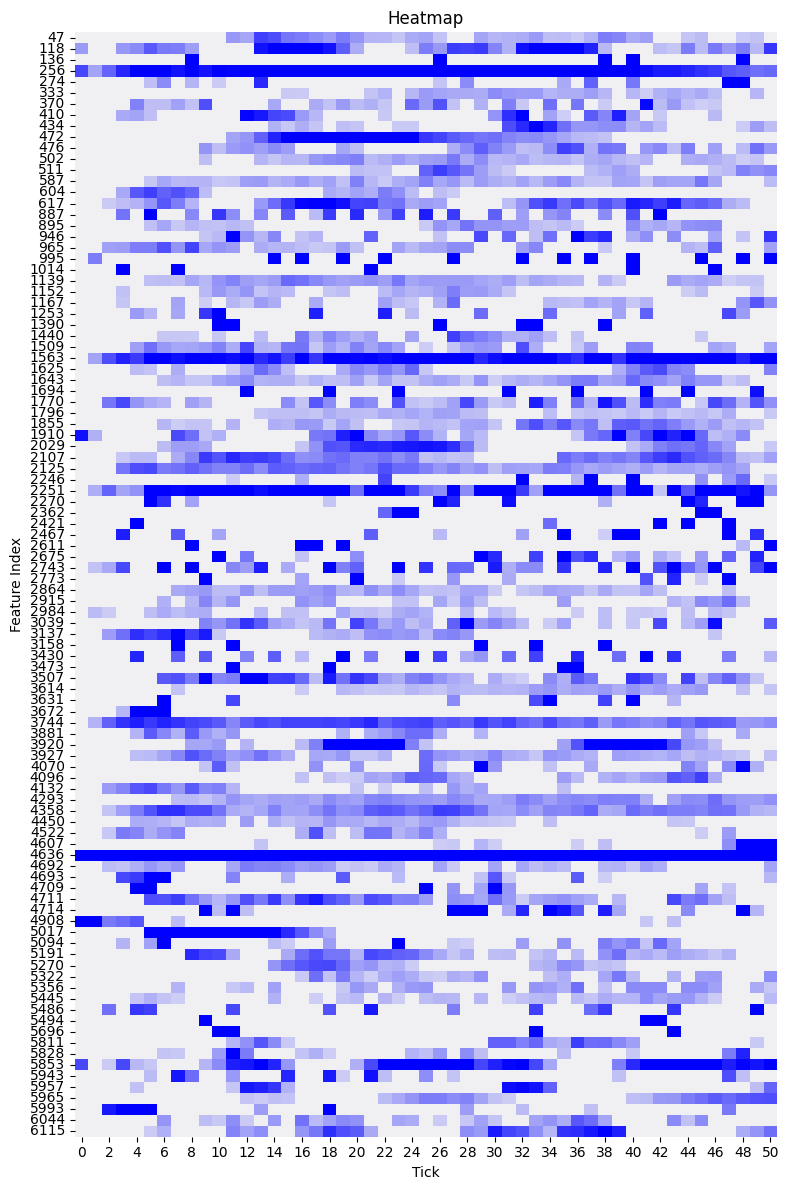

In [12]:
heatmap_c = filter_heatmap_top_k_features(heatmap, 100)
print(len(heatmap_c.keys()))
c = plot_heatmap(heatmap_c)
c.savefig("heatmap_c.png", dpi=300)

In [13]:
from src.audio import (
    get_audio_feature_activations,
    load_audio_file,
    Models,
    SegmentOptions,
    segment_audio_file_by_feature,
    save_audio_to_file,
)

from IPython.display import Audio, display

In [14]:
display(Audio(str(DATA_DIR / "output/musicgen-sae/out_0.wav")))

In [15]:
audio = load_audio_file(DATA_DIR / "output/musicgen-sae/out_0.wav")

act = get_audio_feature_activations(
    audio, Models(model=nn_model, processor=processor, device="cuda:0", layer=layer, ae=ae, sr=model_sr)
)

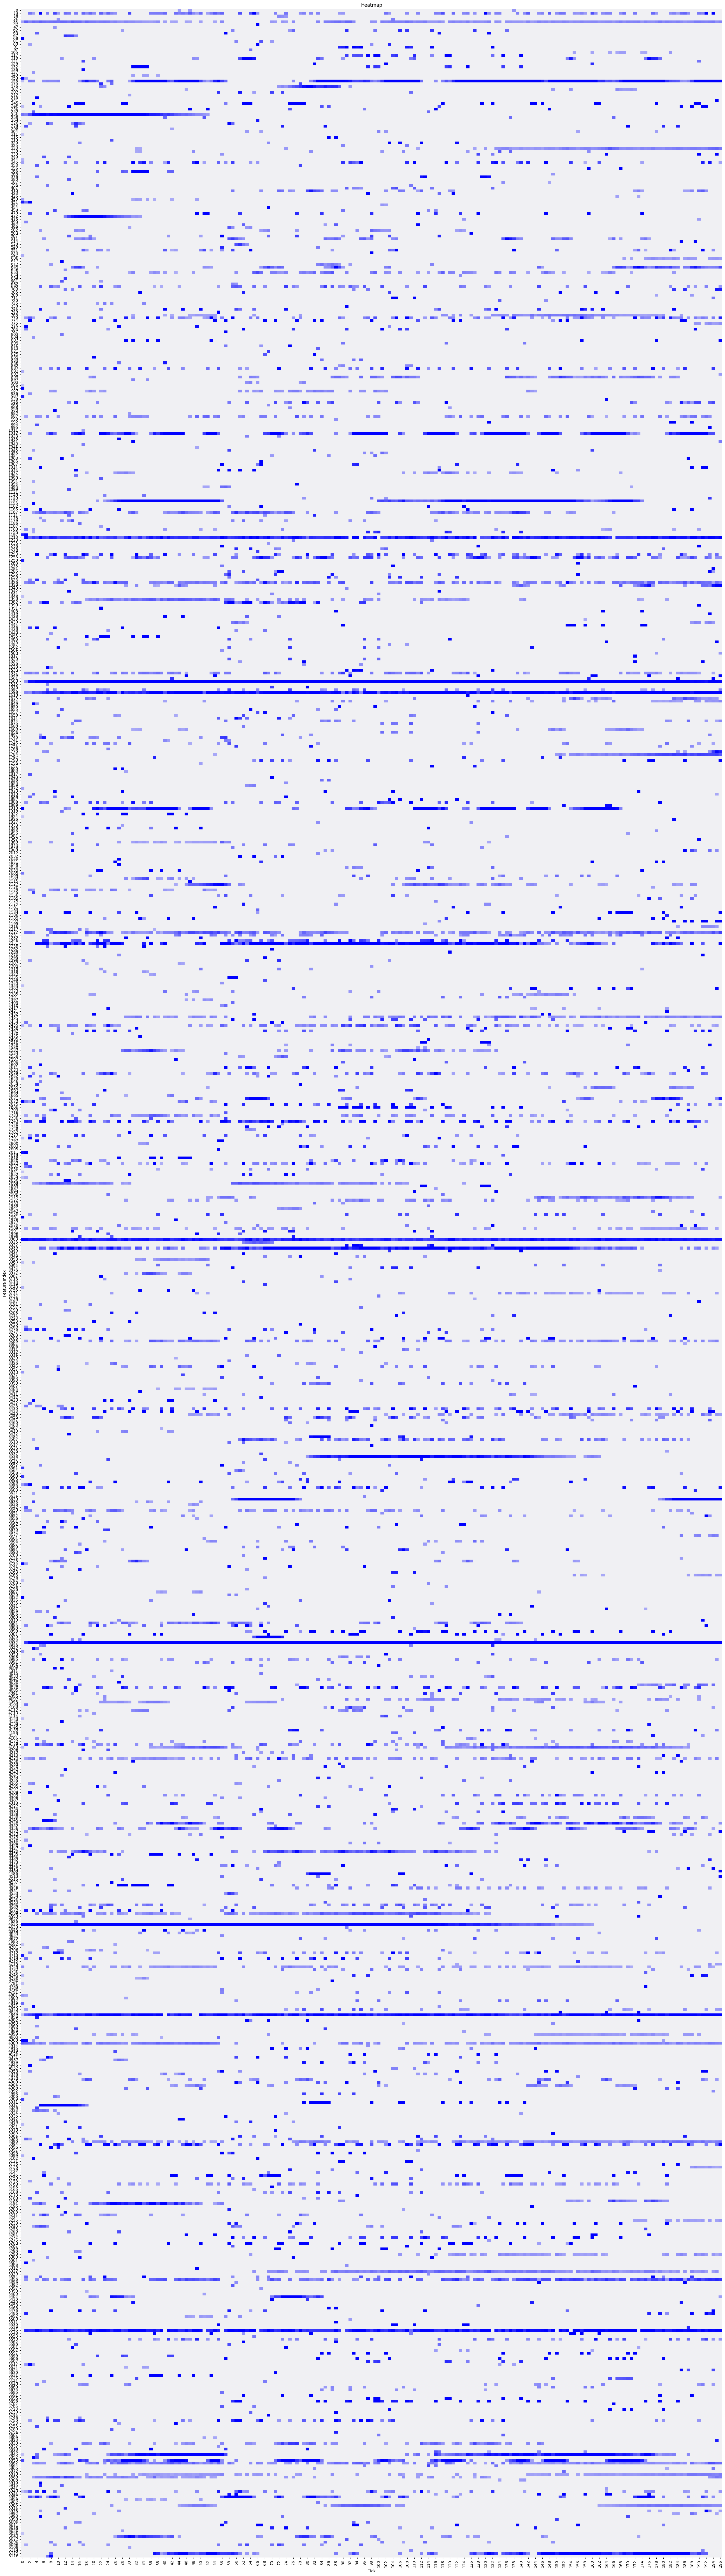

In [16]:
h = create_heatmap(list(act[0]))
p = plot_heatmap(h)
p.savefig("heatmap.png", dpi=300)

In [17]:
segments, timespans = segment_audio_file_by_feature(
    DATA_DIR / "output/musicgen-sae/out_0.wav",
    158,
    Models(model=nn_model, processor=processor, device="cuda:0", layer=layer, ae=ae, sr=model_sr),
    SegmentOptions(min_duration=10),
)

In [18]:
len(segments)

3

In [20]:
for idx, (segment, timespan) in enumerate(zip(segments, timespans)):
    print(timespan)
    save_audio_to_file(torch.tensor(segment), OUTPUT_DATA_DIR / f"segments/s_{idx}.wav")
    display(Audio(str(OUTPUT_DATA_DIR / f"segments/s_{idx}.wav")))

(0.58, 1.16)


(1.6, 2.26)


(2.3, 3.96)
